<a href="https://colab.research.google.com/github/deviandinifebrianti/Machine-Learning/blob/main/Praktikum_%26_Tugas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Praktikum 1
RNN untuk Analisis Sentimen

# **Setup**

In [ ]:
import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()

In [ ]:
import matplotlib.pyplot as plt #membuat grafik dan visualisasi

def plot_graphs(history, metric):#definisiakn fungsi plot_graphs untuk buat rafik
  plt.plot(history.history[metric]) #buat grafik untuk perubahan metrik saat pelatihan dari objek history
  plt.plot(history.history['val_'+metric], '') #Buat grafik metrik validasi
  plt.xlabel("Epochs")#memberi label pada sumbu x
  plt.ylabel(metric)#memberi label pada sumbu y
  plt.legend([metric, 'val_'+metric])#

# **Setup input pipeline**

In [ ]:
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [ ]:
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


In [ ]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])


texts:  [b'Watching this Movie? l thought to myself, what a lot of garbage. These girls must have rocks for brains for even agreeing to be part of it. Waste of time watching it, faint heavens l only hired it. The acting was below standard and story was unbearable. Anyone contemplating watching this film, please save your money. The film has no credit at all. l am a real film buff and this is worse than "Attack of the Green Tomatoes".<br /><br />l only hope that this piece of trash didn\'t cost too much to make. Money would have been better spent on the homeless people of the world. l only hope there isn\'t a sequel in the pipeline.'
 b'I remember a certain Tuesday, the morning of 18/6/02 to be exact. I was dozed off, trying to convince myself to get out of bed when a horrific explosion was heard. I went to the kitchen where I have a view of several neighborhoods in the southern Jerusalem and saw a pillar of smoke rising from a distant point, the sight of the smoke was followed a minute

# **Buat Teks Encoder**

In [ ]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

In [ ]:
#encoder.get_vocabulary() untuk mendapatkan kosakata yang telah dibangun oleh layer TextVectorization
  #kemudian mengonversinya menjadi array numpy
vocab=np.array(encoder.get_vocabulary())
vocab[:20]#cetak 20 ata peratam dalam kosakata

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

In [ ]:
encoded_example=encoder(example)[:3].numpy()
encoded_example

array([[147,  11,  18, ...,   0,   0,   0],
       [ 10, 364,   4, ...,   0,   0,   0],
       [ 10,   1,  11, ...,   0,   0,   0]])

In [ ]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b'Watching this Movie? l thought to myself, what a lot of garbage. These girls must have rocks for brains for even agreeing to be part of it. Waste of time watching it, faint heavens l only hired it. The acting was below standard and story was unbearable. Anyone contemplating watching this film, please save your money. The film has no credit at all. l am a real film buff and this is worse than "Attack of the Green Tomatoes".<br /><br />l only hope that this piece of trash didn\'t cost too much to make. Money would have been better spent on the homeless people of the world. l only hope there isn\'t a sequel in the pipeline.'
Round-trip:  watching this movie [UNK] thought to myself what a lot of [UNK] these girls must have [UNK] for [UNK] for even [UNK] to be part of it waste of time watching it [UNK] [UNK] [UNK] only [UNK] it the acting was [UNK] [UNK] and story was [UNK] anyone [UNK] watching this film please save your money the film has no [UNK] at all [UNK] am a real film 

# **Buat Model**

In [ ]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [ ]:
#cetak apakah setiap lapisan (layer) dalam model mendukung masking atau tidak
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


# **Penjelasan**
Jadi lapisan pertama tidak mendukung masking, 4 lapisan berikutnya mendukung adanya masking

In [ ]:

# predict on a sample text without padding.

sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

1/1 [==============================] - 4s 4s/step
[-0.00719058]


In [ ]:
# predict on a sample text with padding

padding = "the " * 2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])

1/1 [==============================] - 0s 64ms/step
[-0.00719058]


In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

# **Train Model**

In [ ]:
history = model.fit(train_dataset, epochs=10,
validation_data=test_dataset,
validation_steps=30)

Epoch 1/10
391/391 [==============================] - 46s 95ms/step - loss: 0.6079 - accuracy: 0.6106 - val_loss: 0.4294 - val_accuracy: 0.7922
Epoch 2/10
391/391 [==============================] - 26s 65ms/step - loss: 0.3763 - accuracy: 0.8299 - val_loss: 0.3440 - val_accuracy: 0.8484
Epoch 3/10
391/391 [==============================] - 26s 67ms/step - loss: 0.3320 - accuracy: 0.8547 - val_loss: 0.3365 - val_accuracy: 0.8542
Epoch 4/10
391/391 [==============================] - 25s 65ms/step - loss: 0.3189 - accuracy: 0.8615 - val_loss: 0.3289 - val_accuracy: 0.8583
Epoch 5/10
391/391 [==============================] - 25s 64ms/step - loss: 0.3124 - accuracy: 0.8645 - val_loss: 0.3257 - val_accuracy: 0.8573
Epoch 6/10
391/391 [==============================] - 26s 65ms/step - loss: 0.3075 - accuracy: 0.8679 - val_loss: 0.3432 - val_accuracy: 0.8583
Epoch 7/10
391/391 [==============================] - 25s 64ms/step - loss: 0.3072 - accuracy: 0.8674 - val_loss: 0.3249 - val_accuracy:

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)#evaluasi

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 12s 31ms/step - loss: 0.3237 - accuracy: 0.8619
Test Loss: 0.3236822485923767
Test Accuracy: 0.8619199991226196


(0.0, 0.623177683353424)

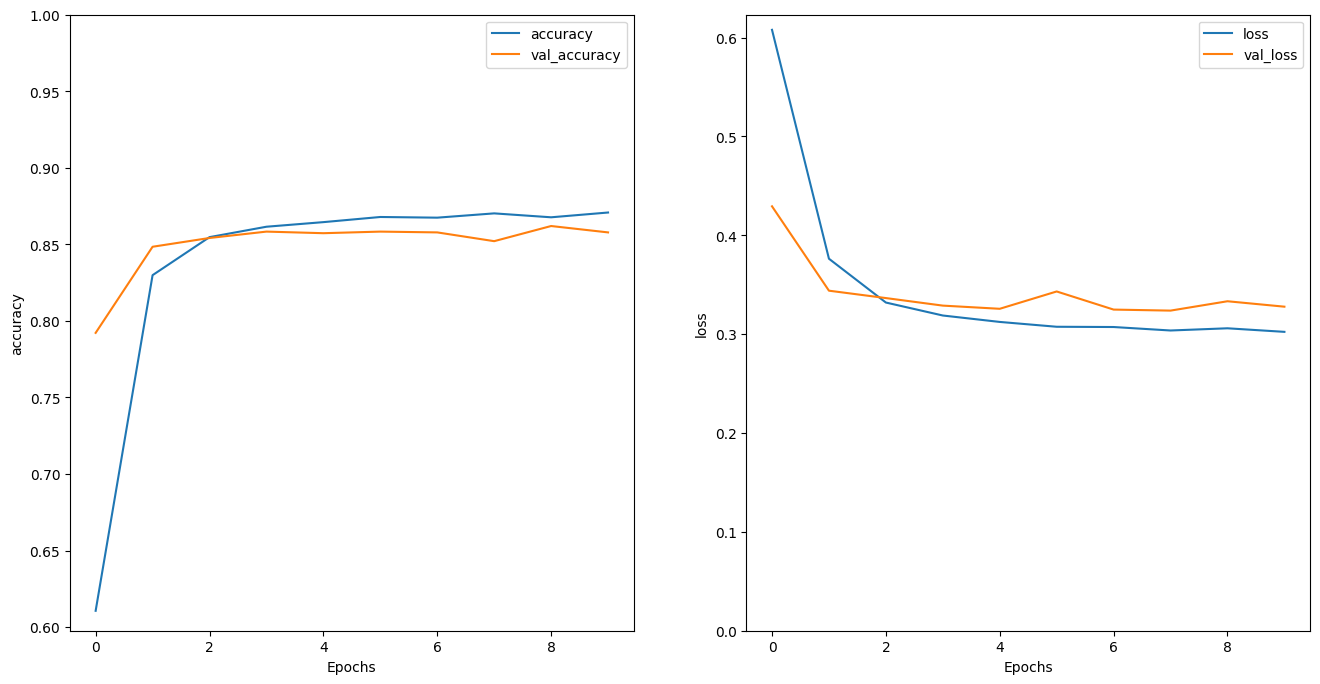

In [ ]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

# **Penjelasan**
Nilai accuracy semakin naik seiring dengan berjalannya epoch, sedangkan loss/kerugian terus berkurang seiring berjalannya epoch

- Accuracy : akurasi model pada data pelatihan selama berjalannya epoch. Jika akurasi pelatihan terus meningkat seiring berjalannya epoch, itu menunjukkan bahwa model belajar dengan baik dari data pelatihan.

- Val Accuracy : akurasi model pada data validasi yang merupakan data yang tidak digunakan dalam pelatihan. Jika akurasi validasi naik bersamaan dengan akurasi pelatihan, itu menunjukkan bahwa model dapat menggeneralisasi dengan baik ke data yang belum pernah dilihat sebelumnya.

- Loss: Nilai kehilangan model pada data pelatihan seiring berjalannya epoch. Jika nilai loss pelatihan terus menurun seiring dengan peningkatan jumlah epoch, itu menunjukkan bahwa model terus mempelajari data pelatihan.

- Val Loss: Validation loss adalah nilai kehilangan model pada data validasi yang merupakan data yang tidak digunakan dalam pelatihan. Jika nilai validation loss juga menurun seiring dengan peningkatan epoch, itu menunjukkan bahwa model dapat melakukan generalisasi dengan baik pada data yang belum pernah dilihat sebelumnya.

In [ ]:
sample_text = ('The movie was cool. The animation and the graphics ''were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))

1/1 [==============================] - 4s 4s/step


# **Penjelasan**
Hasil "1/1" menunjukkan bahwa model memprediksi teks tersebut sebagai sentimen positif dan prediksinya benar.

# **Stack Two or More LSTM Layers**

In [ ]:
model = tf.keras.Sequential([
encoder,
tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
tf.keras.layers.Dense(64, activation='relu'),
tf.keras.layers.Dropout(0.5),
tf.keras.layers.Dense(1)
])

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
optimizer=tf.keras.optimizers.Adam(1e-4),
metrics=['accuracy'])

In [ ]:
history = model.fit(train_dataset, epochs=10,
validation_data=test_dataset,
validation_steps=30)

Epoch 1/10
391/391 [==============================] - 78s 157ms/step - loss: 0.6260 - accuracy: 0.5853 - val_loss: 0.4469 - val_accuracy: 0.7917
Epoch 2/10
391/391 [==============================] - 45s 115ms/step - loss: 0.3970 - accuracy: 0.8290 - val_loss: 0.3554 - val_accuracy: 0.8490
Epoch 3/10
391/391 [==============================] - 46s 118ms/step - loss: 0.3416 - accuracy: 0.8556 - val_loss: 0.3381 - val_accuracy: 0.8521
Epoch 4/10
391/391 [==============================] - 56s 142ms/step - loss: 0.3188 - accuracy: 0.8640 - val_loss: 0.3230 - val_accuracy: 0.8568
Epoch 5/10
391/391 [==============================] - 47s 120ms/step - loss: 0.3108 - accuracy: 0.8676 - val_loss: 0.3302 - val_accuracy: 0.8578
Epoch 6/10
391/391 [==============================] - 45s 116ms/step - loss: 0.3079 - accuracy: 0.8673 - val_loss: 0.3280 - val_accuracy: 0.8620
Epoch 7/10
391/391 [==============================] - 46s 118ms/step - loss: 0.3048 - accuracy: 0.8696 - val_loss: 0.3319 - val_ac

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 19s 50ms/step - loss: 0.3191 - accuracy: 0.8614
Test Loss: 0.3191221356391907
Test Accuracy: 0.8614000082015991


In [ ]:
# predict on a sample text without padding.

sample_text = ('The movie was not good. The animation and the graphics '
'were terrible. I would not recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions)

1/1 [==============================] - 6s 6s/step
[[-1.9903286]]


# **Penjelasan**
Penilaian model rendah terhadap teks

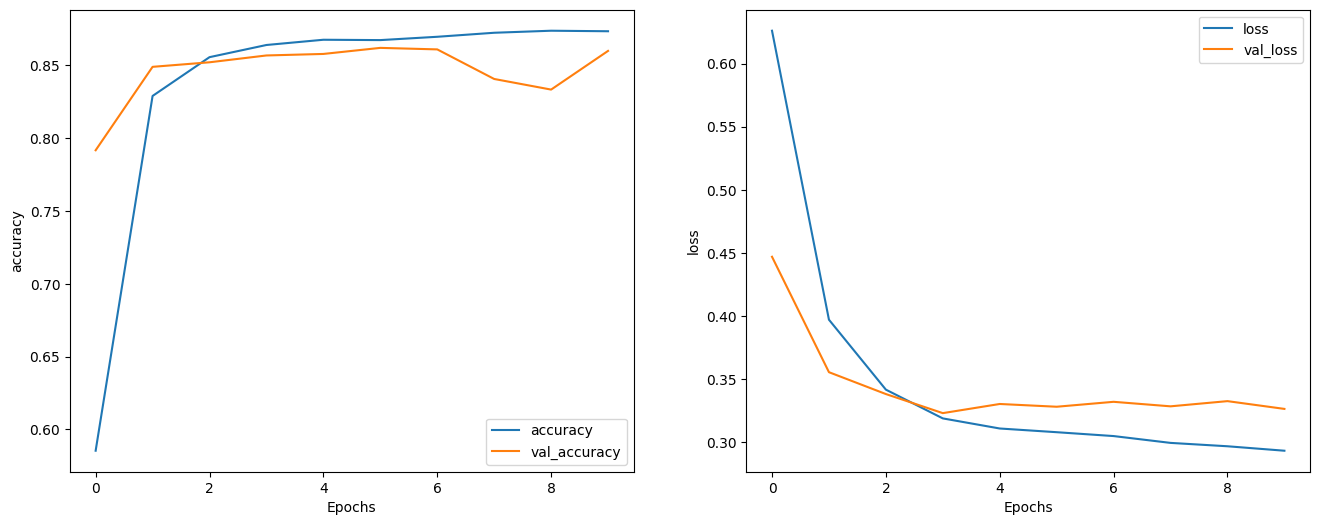

In [ ]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

# **Penjelasan**
- Accuracy : akurasi model pada data pelatihan selama berjalannya epoch. Jika akurasi pelatihan terus meningkat seiring berjalannya epoch, itu menunjukkan bahwa model belajar dengan baik dari data pelatihan.

- Val Accuracy : akurasi model pada data validasi yang merupakan data yang tidak digunakan dalam pelatihan. Jika akurasi validasi naik bersamaan dengan akurasi pelatihan, itu menunjukkan bahwa model dapat menggeneralisasi dengan baik ke data yang belum pernah dilihat sebelumnya.

- Loss: Nilai kehilangan model pada data pelatihan seiring berjalannya epoch. Jika nilai loss pelatihan terus menurun seiring dengan peningkatan jumlah epoch, itu menunjukkan bahwa model terus mempelajari data pelatihan.

- Val Loss: Validation loss adalah nilai kehilangan model pada data validasi yang merupakan data yang tidak digunakan dalam pelatihan. Jika nilai validation loss juga menurun seiring dengan peningkatan epoch, itu menunjukkan bahwa model dapat melakukan generalisasi dengan baik pada data yang belum pernah dilihat sebelumnya.

# Praktikum 2
Generator Teks dengan RNN

**1. Import TensorFlow**

In [ ]:
import tensorflow as tf
import numpy as np
import os
import time

**2. Download Dataset Shakespeare**

In [ ]:
path_to_file = tf.keras.utils.get_file('shakespeare.txt', 'https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt')

1115394/1115394 [==============================] - 0s 0us/step


**3. Load Data**

In [ ]:
# Read, then decode for py2 compat.
text = open(path_to_file, 'rb').read().decode(encoding='utf-8')
# length of text is the number of characters in it
print(f'Length of text: {len(text)} characters')

Length of text: 1115394 characters


In [ ]:
# Take a look at the first 250 characters in text
print(text[:250])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.



In [ ]:
# The unique characters in the file
vocab = sorted(set(text))
print(f'{len(vocab)} unique characters')

65 unique characters


# **Olah Teks**
**Vectorize Teks**

In [ ]:
example_texts = ['abcdefg', 'xyz']
chars = tf.strings.unicode_split(example_texts, input_encoding='UTF-8')
chars

<tf.RaggedTensor [[b'a', b'b', b'c', b'd', b'e', b'f', b'g'], [b'x', b'y', b'z']]>

In [ ]:
ids_from_chars=tf.keras.layers.StringLookup(vocabulary=list(vocab),mask_token=None)

In [ ]:
ids=ids_from_chars(chars)
ids

<tf.RaggedTensor [[40, 41, 42, 43, 44, 45, 46], [63, 64, 65]]>

In [ ]:
chars_from_ids = tf.keras.layers.StringLookup(
    vocabulary=ids_from_chars.get_vocabulary(), invert=True, mask_token=None)

In [ ]:
chars=chars_from_ids(ids)
chars

<tf.RaggedTensor [[b'a', b'b', b'c', b'd', b'e', b'f', b'g'], [b'x', b'y', b'z']]>

In [ ]:
tf.strings.reduce_join(chars,axis=-1).numpy()

array([b'abcdefg', b'xyz'], dtype=object)

In [ ]:
def text_from_ids(ids):
  return tf.strings.reduce_join(chars_from_ids(ids), axis=-1)

# **Prediksi**
**Membuat Traning Set dan Target**

In [ ]:
all_ids = ids_from_chars(tf.strings.unicode_split(text, 'UTF-8'))
all_ids

<tf.Tensor: shape=(1115394,), dtype=int64, numpy=array([19, 48, 57, ..., 46,  9,  1])>

In [ ]:
ids_dataset= tf.data.Dataset.from_tensor_slices(all_ids)

In [ ]:
for ids in ids_dataset.take(10):
    print(chars_from_ids(ids).numpy().decode('utf-8'))

F
i
r
s
t
 
C
i
t
i


In [ ]:
seq_length = 100

In [ ]:
sequences = ids_dataset.batch(seq_length+1, drop_remainder=True)

for seq in sequences.take(1):
  print(chars_from_ids(seq))

tf.Tensor(
[b'F' b'i' b'r' b's' b't' b' ' b'C' b'i' b't' b'i' b'z' b'e' b'n' b':'
 b'\n' b'B' b'e' b'f' b'o' b'r' b'e' b' ' b'w' b'e' b' ' b'p' b'r' b'o'
 b'c' b'e' b'e' b'd' b' ' b'a' b'n' b'y' b' ' b'f' b'u' b'r' b't' b'h'
 b'e' b'r' b',' b' ' b'h' b'e' b'a' b'r' b' ' b'm' b'e' b' ' b's' b'p'
 b'e' b'a' b'k' b'.' b'\n' b'\n' b'A' b'l' b'l' b':' b'\n' b'S' b'p' b'e'
 b'a' b'k' b',' b' ' b's' b'p' b'e' b'a' b'k' b'.' b'\n' b'\n' b'F' b'i'
 b'r' b's' b't' b' ' b'C' b'i' b't' b'i' b'z' b'e' b'n' b':' b'\n' b'Y'
 b'o' b'u' b' '], shape=(101,), dtype=string)


In [ ]:
for seq in sequences.take(5):
    print(text_from_ids(seq).numpy())

b'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '
b'are all resolved rather to die than to famish?\n\nAll:\nResolved. resolved.\n\nFirst Citizen:\nFirst, you k'
b"now Caius Marcius is chief enemy to the people.\n\nAll:\nWe know't, we know't.\n\nFirst Citizen:\nLet us ki"
b"ll him, and we'll have corn at our own price.\nIs't a verdict?\n\nAll:\nNo more talking on't; let it be d"
b'one: away, away!\n\nSecond Citizen:\nOne word, good citizens.\n\nFirst Citizen:\nWe are accounted poor citi'


In [ ]:
def split_input_target(sequence):
    input_text = sequence[:-1]
    target_text = sequence[1:]
    return input_text, target_text

In [ ]:
split_input_target(list("Tensorflow"))

(['T', 'e', 'n', 's', 'o', 'r', 'f', 'l', 'o'],
 ['e', 'n', 's', 'o', 'r', 'f', 'l', 'o', 'w'])

In [ ]:
dataset = sequences.map(split_input_target)

In [ ]:
for input_example, target_example in dataset.take(1):
    print("Input :", text_from_ids(input_example).numpy())
    print("Target:", text_from_ids(target_example).numpy())

Input : b'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou'
Target: b'irst Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '


**Membuat Batch Training**

In [ ]:
# Batch size
BATCH_SIZE = 64

# Buffer size to shuffle the dataset
# (TF data is designed to work with possibly infinite sequences,
# so it doesn't attempt to shuffle the entire sequence in memory. Instead,
# it maintains a buffer in which it shuffles elements).
BUFFER_SIZE = 10000

dataset = (
    dataset
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.experimental.AUTOTUNE))

dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(64, 100), dtype=tf.int64, name=None), TensorSpec(shape=(64, 100), dtype=tf.int64, name=None))>

**Buat Model**

In [ ]:
# Length of the vocabulary in StringLookup Layer
vocab_size = len(ids_from_chars.get_vocabulary())

# The embedding dimension
embedding_dim = 256

# Number of RNN units
rnn_units = 1024

In [ ]:
class MyModel(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, rnn_units):
    super().__init__(self)
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(rnn_units,
                                   return_sequences=True,
                                   return_state=True)
    self.dense = tf.keras.layers.Dense(vocab_size)

  def call(self, inputs, states=None, return_state=False, training=False):
    x = inputs
    x = self.embedding(x, training=training)
    if states is None:
      states = self.gru.get_initial_state(x)
    x, states = self.gru(x, initial_state=states, training=training)
    x = self.dense(x, training=training)

    if return_state:
      return x, states
    else:
      return x

In [ ]:
model = MyModel(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    rnn_units=rnn_units)

**Uji Model**

In [ ]:
for input_example_batch, target_example_batch in dataset.take(1):
    example_batch_predictions = model(input_example_batch)
    print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

(64, 100, 66) # (batch_size, sequence_length, vocab_size)


In [ ]:
model.summary()

Model: "my_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       multiple                  16896     
                                                                 
 gru (GRU)                   multiple                  3938304   
                                                                 
 dense (Dense)               multiple                  67650     
                                                                 
Total params: 4022850 (15.35 MB)
Trainable params: 4022850 (15.35 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
sampled_indices = tf.random.categorical(example_batch_predictions[0], num_samples=1)
sampled_indices = tf.squeeze(sampled_indices, axis=-1).numpy()

In [ ]:
sampled_indices

array([35, 56,  8,  0,  6, 41,  6, 23, 44, 10, 49, 31, 52, 32, 33,  2, 54,
       33, 26, 43, 30, 64, 35, 28,  2, 45, 43, 12, 17, 31,  3, 21, 57, 45,
       19,  0,  2, 32, 52, 21, 25, 11, 36,  0, 16, 55, 42, 41, 46, 29, 65,
       45, 64, 29, 44,  6, 44, 17, 41, 31, 35, 42,  9, 61, 11, 65, 17, 56,
       16, 31, 32, 24,  9,  6, 51, 51, 60,  5, 16, 22, 64,  7, 36, 11,  0,
       30, 20, 14, 19, 45, 59, 63, 64, 14, 46, 63, 22, 28, 39, 37])

In [ ]:
print("Input:\n", text_from_ids(input_example_batch[0]).numpy())
print()
print("Next Char Predictions:\n", text_from_ids(sampled_indices).numpy())

Input:
 b'race so pale?\n\nKING RICHARD II:\nBut now the blood of twenty thousand men\nDid triumph in my face, and'

Next Char Predictions:
 b"Vq-[UNK]'b'Je3jRmST oTMdQyVO fd;DR!HrfF[UNK] SmHL:W[UNK]CpcbgPzfyPe'eDbRVc.v:zDqCRSK.'llu&CIy,W:[UNK]QGAFftxyAgxIOZX"


# **Train Model**
**Tambahan Optimizer dan Fungsi Loss**

In [ ]:
loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True)

In [ ]:
example_batch_mean_loss = loss(target_example_batch, example_batch_predictions)
print("Prediction shape: ", example_batch_predictions.shape, " # (batch_size, sequence_length, vocab_size)")
print("Mean loss:        ", example_batch_mean_loss)

Prediction shape:  (64, 100, 66)  # (batch_size, sequence_length, vocab_size)
Mean loss:         tf.Tensor(4.1885324, shape=(), dtype=float32)


In [ ]:
tf.exp(example_batch_mean_loss).numpy()

65.925964

In [ ]:
model.compile(optimizer='adam', loss=loss)

**Konfigurasi Checkpoints**

In [ ]:
# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

**Lakukan Proses Training**

In [ ]:
EPOCHS = 20

In [ ]:
history = model.fit(dataset, epochs=EPOCHS, callbacks=[checkpoint_callback])

Epoch 1/20
172/172 [==============================] - 15s 55ms/step - loss: 2.7469
Epoch 2/20
172/172 [==============================] - 11s 54ms/step - loss: 2.0076
Epoch 3/20
172/172 [==============================] - 11s 55ms/step - loss: 1.7247
Epoch 4/20
172/172 [==============================] - 11s 56ms/step - loss: 1.5595
Epoch 5/20
172/172 [==============================] - 11s 57ms/step - loss: 1.4590
Epoch 6/20
172/172 [==============================] - 11s 58ms/step - loss: 1.3906
Epoch 7/20
172/172 [==============================] - 12s 59ms/step - loss: 1.3373
Epoch 8/20
172/172 [==============================] - 12s 60ms/step - loss: 1.2926
Epoch 9/20
172/172 [==============================] - 11s 57ms/step - loss: 1.2506
Epoch 10/20
172/172 [==============================] - 11s 58ms/step - loss: 1.2112
Epoch 11/20
172/172 [==============================] - 12s 58ms/step - loss: 1.1728
Epoch 12/20
172/172 [==============================] - 11s 57ms/step - loss: 1.1316
E

**Generate Teks**

In [ ]:
class OneStep(tf.keras.Model):
  def __init__(self, model, chars_from_ids, ids_from_chars, temperature=1.0):
    super().__init__()
    self.temperature = temperature
    self.model = model
    self.chars_from_ids = chars_from_ids
    self.ids_from_chars = ids_from_chars

    # Create a mask to prevent "[UNK]" from being generated.
    skip_ids = self.ids_from_chars(['[UNK]'])[:, None]
    sparse_mask = tf.SparseTensor(
        # Put a -inf at each bad index.
        values=[-float('inf')]*len(skip_ids),
        indices=skip_ids,
        # Match the shape to the vocabulary
        dense_shape=[len(ids_from_chars.get_vocabulary())])
    self.prediction_mask = tf.sparse.to_dense(sparse_mask)

  @tf.function
  def generate_one_step(self, inputs, states=None):
    # Convert strings to token IDs.
    input_chars = tf.strings.unicode_split(inputs, 'UTF-8')
    input_ids = self.ids_from_chars(input_chars).to_tensor()

    # Run the model.
    # predicted_logits.shape is [batch, char, next_char_logits]
    predicted_logits, states = self.model(inputs=input_ids, states=states,
                                          return_state=True)
    # Only use the last prediction.
    predicted_logits = predicted_logits[:, -1, :]
    predicted_logits = predicted_logits/self.temperature
    # Apply the prediction mask: prevent "[UNK]" from being generated.
    predicted_logits = predicted_logits + self.prediction_mask

    # Sample the output logits to generate token IDs.
    predicted_ids = tf.random.categorical(predicted_logits, num_samples=1)
    predicted_ids = tf.squeeze(predicted_ids, axis=-1)

    # Convert from token ids to characters
    predicted_chars = self.chars_from_ids(predicted_ids)

    # Return the characters and model state.
    return predicted_chars, states

In [ ]:
one_step_model = OneStep(model, chars_from_ids, ids_from_chars)

In [ ]:
start = time.time()
states = None
next_char = tf.constant(['ROMEO:'])
result = [next_char]

for n in range(1000):
  next_char, states = one_step_model.generate_one_step(next_char, states=states)
  result.append(next_char)

result = tf.strings.join(result)
end = time.time()
print(result[0].numpy().decode('utf-8'), '\n\n' + '_'*80)
print('\nRun time:', end - start)

ROMEO:
But all in all that I am here.
Here in LiUCESTER:
And that thy fortunes were better to look voil,
Whate'er thou wert this, boy, impatiented with a quarrel.

CAPULET:
And but the kiter for the world Keeps is yet blown
to tilous forted her to beat born to do't.

MENENIUS:
Ons true; Lewis'd princiscomp, and terrison thee.

Gentleman:
I would King Henry's groats, imprigoning ourselves rise:
Hold, all agrees, treasonable accusers!

CAPULET:
Well, beling thee. Where is the singul of the king?

NORTHUMBERLAND:
How now! most true!

AUTOLYCUS:
I am going to that, so: indeed, I hope to stood to me;
And, sweeter, you dreamt, being plague these golden heart
Unto dimmise; or else derived you
Of all esselved.

SEBASTIAN:
What, are you set at once; unmuches with
numbering stars? on 'twas no poor Here imperate peace
Paunded a million of healthood in the shadow
That were some spite of their a, he looks
In lost sheep, let them be, and me
And Richard leave of a well; and love thee,
Avoint the noth

In [ ]:
start = time.time()
states = None
next_char = tf.constant(['ROMEO:', 'ROMEO:', 'ROMEO:', 'ROMEO:', 'ROMEO:'])
result = [next_char]

for n in range(1000):
  next_char, states = one_step_model.generate_one_step(next_char, states=states)
  result.append(next_char)

result = tf.strings.join(result)
end = time.time()
print(result, '\n\n' + '_'*80)
print('\nRun time:', end - start)

tf.Tensor(
[b"ROMEO:\nI shall pospect to you, in the earth owed;\nat their crownsing troops that ever he kill'd\nWhen badies in mock'd while Lauren Margaret\nOf all echoss'd office Putis show'd in thee,\nFarewell; repeal'st too grief as he kept not to be gone?\n\nGREMIO:\nMy gracious sixteen years,\nI cannot believe you. Take up,\nI will appeach and thine own willowings thou.\nNay, we must not--he, in the cheeks of him,\nFor it is not for the appetitoo; which,\nGod and up his bone.\n\nESCALUS:\nI think, you now go with you; I will not: besides, they lie with thee but ta'en\nTo Richmond. Baducle!\nNept not of all whights he know\nOf all the purple thanks I have true attend on the face\nTo set the curt a-go, but only so foul with,--\n\nSEBASTIAN:\nIt is no less than he.\n\nBoth: Waste!\nShe's very well; for whom we came to shame thee,\nAnd be no tall in nor he sleep. There is mad, an\naccured begin our courtabity.\n\nSOMERSET:\nAh, Would all dead will hear you thanks?\n\nPROSPERO:\nKnow 

**Ekspor Model Generator**

In [ ]:
tf.saved_model.save(one_step_model, 'one_step')
one_step_reloaded = tf.saved_model.load('one_step')

In [ ]:
states = None
next_char = tf.constant(['ROMEO:'])
result = [next_char]

for n in range(100):
  next_char, states = one_step_reloaded.generate_one_step(next_char, states=states)
  result.append(next_char)

print(tf.strings.join(result)[0].numpy().decode("utf-8"))

ROMEO:
He speaks the queen to do him injury to me,
He is as tears to stoop with Marvaus I spoke,
And yet t


# Tugas
Gunakan tf.GradientTape untuk men track nilai gradient. Anda dapat mempelajari lebih lanjut tentang pendekatan ini dengan membaca eager execution guide. Prosedurnya adalah "

1. Jalankan Model dan hitung loss dengan tf.GradientTape.
2. Hitung update dan terapkan pada model dengan optimizer

In [ ]:
class CustomTraining(MyModel):#mendefinisikan kelas CustomTraining yang merupakan turunan dari MyModel
     @tf.function
     def train_step(self, inputs):#digunakan untuk melatih model dengan satu langkah (step) selama proses pelatihan
        inputs, labels = inputs#memisahkan inputs menjadi inputs dan labels. inputs adalah masukan model, dan labels adalah target yang seharusnya diprediksi oleh model.
        with tf.GradientTape() as tape:#untuk menghitung gradien (gradient) dari fungsi kerugian terhadap parameter model.
            predictions = self(inputs, training=True)#untuk enghasilkan prediksi model
            loss = self.loss(labels, predictions)#enghitung nilai kerugian (loss) dengan membandingkan prediksi model dengan label yang seharusnya diprediksi
            grads = tape.gradient(loss, model.trainable_variables)#menghitung gradien (gradient) dari kerugian terhadap parameter-parameter yang dapat diubah dalam model (trainable variables)
            self.optimizer.apply_gradients(zip(grads, model.trainable_variables))#mengaplikasikan gradien ke parameter-parameter model, sehingga model dapat diperbarui selama pelatihan.

            return {'loss': loss}#mengembalikan dictionary yang berisi nilai kerugian (loss)

In [ ]:
#membuat objek model dengan menggunakan kelas CustomTraining dengan 3 parameter
model = CustomTraining(
    vocab_size=len(ids_from_chars.get_vocabulary()),#memberikan informasi berapa banyak karakter yang ada dalam vokabulari model.
    embedding_dim=embedding_dim,#dimensi embedding yang digunakan dalam model.
    rnn_units=rnn_units)#jumlah unit dalam lapisan RNN model.

In [ ]:
#compile model
model.compile(optimizer = tf.keras.optimizers.Adam(),#digunakan untuk mengoptimalkan parameter-parameter model selama pelatihan
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True))#menghasilkan logit (skor) langsung, dan kerugian akan menghitung probabilitas berdasarkan logit yang dihasilkan

In [ ]:
model.fit(dataset, epochs=1)#elatih model Anda selama satu epoch

172/172 [==============================] - 15s 59ms/step - loss: 2.7076


In [ ]:
EPOCHS = 10#memberi nilai iterasi epoch

mean = tf.metrics.Mean()#ntuk menghitung rata-rata loss selama pelatihan

for epoch in range(EPOCHS):#pelatihan
    start = time.time()#menghitung berapa lama satu epoch akan berlangsung.

    mean.reset_states()#mereset nilai rata-rata loss di awal setiap epoch untuk menghitung rata-rata loss selama epoch tersebut
    for (batch_n, (inp, target)) in enumerate(dataset):#oop dalam dataset yang berisi data latihan
        logs = model.train_step([inp, target])#melatih model pada batch saat ini. Metode ini mengembalikan nilai loss pada batch tersebut.
        mean.update_state(logs['loss'])#memperbarui nilai rata-rata loss dengan loss pada batch saat ini.

        if batch_n % 50 == 0:#mencetak loss setiap 50 batch untuk memantau perkembangan pelatihan.
            template = f"Epoch {epoch+1} Batch {batch_n} Loss {logs['loss']:.4f}"
            print(template)

    # saving (checkpoint) the model every 5 epochs
    if (epoch + 1) % 5 == 0:
      model.save_weights(checkpoint_prefix.format(epoch=epoch))#menyimpan parameter-parameter model dalam bentuk checkpoint

    print()
    print(f'Epoch {epoch+1} Loss: {mean.result().numpy():.4f}')#cetak informasi tentang epoch saat ini, termasuk nomor epoch dan rata-rata loss yang dihasilkan selama epoch tersebut
    print(f'Time taken for 1 epoch {time.time() - start:.2f} sec')#cetak berapa lama waktu yang diperlukan untuk menyelesaikan satu epoch dalam detik.
    print("_"*80)#cetak garis pemisah berupa karakter garis bawah underscore

model.save_weights(checkpoint_prefix.format(epoch=epoch))##menyimpan parameter-parameter model dalam bentuk checkpoint

Epoch 1 Batch 0 Loss 2.1728
Epoch 1 Batch 50 Loss 2.0300
Epoch 1 Batch 100 Loss 1.9609
Epoch 1 Batch 150 Loss 1.8589

Epoch 1 Loss: 1.9900
Time taken for 1 epoch 14.89 sec
________________________________________________________________________________
Epoch 2 Batch 0 Loss 1.8197
Epoch 2 Batch 50 Loss 1.7278
Epoch 2 Batch 100 Loss 1.6712
Epoch 2 Batch 150 Loss 1.6198

Epoch 2 Loss: 1.7103
Time taken for 1 epoch 11.70 sec
________________________________________________________________________________
Epoch 3 Batch 0 Loss 1.5891
Epoch 3 Batch 50 Loss 1.5697
Epoch 3 Batch 100 Loss 1.5639
Epoch 3 Batch 150 Loss 1.4916

Epoch 3 Loss: 1.5480
Time taken for 1 epoch 11.40 sec
________________________________________________________________________________
Epoch 4 Batch 0 Loss 1.4665
Epoch 4 Batch 50 Loss 1.4522
Epoch 4 Batch 100 Loss 1.3932
Epoch 4 Batch 150 Loss 1.4804

Epoch 4 Loss: 1.4481
Time taken for 1 epoch 11.17 sec
_____________________________________________________________________

**Perbedaan dengan praktikum 2**

Praktikum 2 menggunakan pendekatan pelatihan yang sederhana dan umum sedangkan tugas menggunakan metode model fit().

- Praktikum 2 (Fungsionalitas Keras)
Lebih banyak menggunakan fungsionalitas dari TensorFlow, Menggunakan lapisan keras: GRU dan dense yang berguna untuk memudahkan mengelola sebagian besar operasi, model dilatih dengan motode fit(), Potongan kode juga menggunakan callbacks dalam proses pelatihan seperti halnya ModelCheckpoint untuk menyimpan bobot model setelah setiap epoch.
- Tugas (Model Custom)
menggunakan model secara manual dengan pendekatan yang lebih langsung, Pembuatan Model dan Pelatihan Langsung dengan membuat kelas CustomTraining yang mewarisi MyModel. Kemudian mendefinisikan fungsi train_step secara eksplisit untuk melakukan langkah pelatihan (training step) menggunakan tf.
Loop pelatihan eksplisit yang mengatur pelatihan dalam epoch dan batch secara terperinci.